# Turizam


In [1]:
# Standardna Python biblioteka.
import copy
import functools
import math
import numbers
import warnings

# SciPy paketi.
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Paket TensorLy.
from tensorly.decomposition import parafac

# Paket StatsModels.
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Paket Hyperopt.
import hyperopt as ho


Using numpy backend.


In [2]:
%matplotlib inline


In [3]:
from tlp import *


## Učitavanje podataka


In [4]:
raw_df = pd.read_csv(
    'data/BS_TU12.csv',
    header = 0,
    index_col = None,
    encoding = 'utf-8'
)


In [5]:
df16 = raw_df[['Županije', 'Mjesec', 'Tip', '2016 Domaći', '2016 Strani']].copy()
df17 = raw_df[['Županije', 'Mjesec', 'Tip', '2017 Domaći', '2017 Strani']].copy()
df18 = raw_df[['Županije', 'Mjesec', 'Tip', '2018 Domaći', '2018 Strani']].copy()

df16.columns = ['Županije', 'Mjesec', 'Tip', 'Domaći', 'Strani']
df17.columns = ['Županije', 'Mjesec', 'Tip', 'Domaći', 'Strani']
df18.columns = ['Županije', 'Mjesec', 'Tip', 'Domaći', 'Strani']

df16.reset_index(drop = True, inplace = True)
df17.reset_index(drop = True, inplace = True)
df18.reset_index(drop = True, inplace = True)


In [6]:
df = pd.concat((df16, df17, df18), axis = 0, ignore_index = True)


In [7]:
županije = np.array(df['Županije'].unique())
po_županijama = df.groupby('Županije')


In [8]:
Z = np.zeros((4, len(po_županijama.groups), 3 * 12), dtype = int, order = 'F')
for i in iter(range(int(županije.size))):
    aux_df = po_županijama.get_group(županije[i]).reset_index(drop = True).copy()
    Z[0, i, :] = aux_df.loc[0::2, 'Domaći']
    Z[1, i, :] = aux_df.loc[0::2, 'Strani']
    Z[2, i, :] = aux_df.loc[1::2, 'Domaći']
    Z[3, i, :] = aux_df.loc[1::2, 'Strani']
    del aux_df
try:
    del i
except (NameError, UnboundLocalError):
    pass


In [9]:
np.save('data/turizam.npy', Z)


In [10]:
del raw_df
del df16
del df17
del df18
del po_županijama
del županije
del df


## Predviđanje


In [11]:
Z = np.load('data/turizam.npy')


In [12]:
Z_mean = Z.mean(axis = -1).reshape((4, 21, 1)).copy(order = 'F')
Z_std = Z.std(axis = -1, ddof = 1).reshape((4, 21, 1)).copy(order = 'F')

Z_norm = (Z - Z_mean) / Z_std


In [13]:
Z_log = np.log(Z).copy(order = 'F')

Z_log_mean = Z_log.mean(axis = -1).reshape((4, 21, 1)).copy(order = 'F')
Z_log_std = Z_log.std(axis = -1, ddof = 1).reshape((4, 21, 1)).copy(order = 'F')

Z_log_norm = (Z_log - Z_log_mean) / Z_log_std


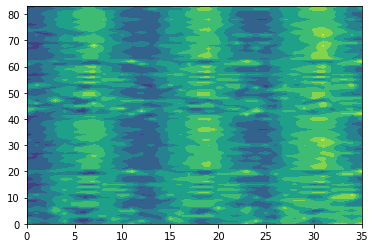

In [14]:
U, V = np.meshgrid(
    np.arange(Z.shape[2], dtype = int),
    np.arange(Z.shape[0] * Z.shape[1], dtype = int),
    indexing = 'xy'
)
W = np.array(
    [Z_log_norm[:, :, i].ravel() for i in iter(range(int(Z.shape[2])))],
    dtype = float,
    order = 'F'
).T.copy(order = 'F')
try:
    del i
except (NameError, UnboundLocalError):
    pass

fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.contourf(U, V, W)
plt.show()


In [15]:
del U
del V
del W

del fig
del ax


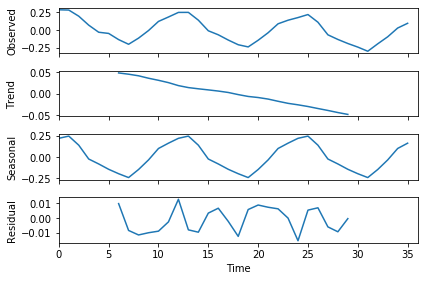

In [16]:
cpd = list(parafac(Z_log_norm.astype(float), 1))
for i in iter(range(len(cpd))):
    cpd[i] = cpd[i].ravel().copy(order = 'F')
try:
    del i
except (NameError, UnboundLocalError):
    pass

seasonal_decompose(cpd[-1], freq = 12).plot()
adfuller(cpd[-1])
plt.show()


In [17]:
del cpd


In [18]:
def mse (a, b):
    e = np.abs(b - a)

    if isinstance(e, np.ndarray):
        e = np.sqrt(np.square(e).mean())

    return e


In [19]:
def rel_mse (a, b):
    e = np.abs((b - a) / np.maximum(np.abs(a), 1))

    if isinstance(e, np.ndarray):
        e = np.sqrt(np.square(e).mean())

    return e


In [20]:
def optim (
    space,
    Z,
    loss,
    k = None,
    T0 = None,
    p = None,
    n = None,
    theta = None
):
    """
    space: rječnik hiperparametara,
    Z: kompletni tenzor (s rezovima koje treba predvidjeti),
    loss: funkcija za računanje greške,
    k: broj komponenti u CP dekompoziciji,
    T0: broj rezova koji se uzimaju u obzir kod predikcije,
    p: duljina perioda,
    n: broj zadnjih rezova u Z koje treba predvidjeti,
    theta: oblik (oblika) paramet(a)ra theta u eksponencijalnom izglađivanju.

    """

    if 'k' in space:
        assert k is None
    if 'T0' in space:
        assert T0 is None
    assert (p is None) == ('p' in space)
    assert (n is None) == ('n' in space)
    assert (
        (
            theta is None or (isinstance(theta, bool) and not theta)
        ) == ('theta' in space)
    )

    if n is None:
        n = int(round(space['n']))

    fill_theta = True
    if isinstance(theta, bool):
        if not theta:
            theta = space['theta']
            fill_theta = False
    if fill_theta:
        if theta is None:
            theta = space['theta']
        if isinstance(theta, numbers.Integral):
            theta = np.zeros(theta, dtype = float, order = 'F')
            for i in iter(range(int(theta.size))):
                theta[i] = space['theta[{0:d}]'.format(i)]
        else:
            if not isinstance(theta, tuple):
                if isinstance(theta, np.ndarray):
                    theta = copy.deepcopy((theta, theta, theta))
                else:
                    if hasattr(theta, '__iter__'):
                        theta = copy.deepcopy(tuple(theta))
                    else:
                        theta = copy.deepcopy((theta, theta, theta))
            else:
                theta = copy.deepcopy(theta)
            if len(theta) != 3:
                theta = copy.deepcopy((theta, theta, theta))
            theta = list(theta)
            for i in iter(range(3)):
                theta[i] = np.zeros(theta[i], dtype = float, order = 'C')
                idx = np.array(
                    np.meshgrid(
                        *tuple(
                            np.arange(theta[i].shape[j], dtype = int)
                                for j in iter(range(int(theta[i].ndim)))
                        )
                    )
                ).T.reshape((-1, theta[i].ndim)).copy(order = 'C')
                for j in iter(range(int(idx.shape[0]))):
                    theta[i][tuple(idx[j])] = (
                        space[
                            'theta[{0:s}]'.format(
                                ','.join(
                                    str(r)
                                        for r in np.concatenate(
                                            ([i], idx[j])
                                        )
                                )
                            )
                        ]
                    )
                try:
                    del j
                except (NameError, UnboundLocalError):
                    pass
            try:
                del i
            except (NameError, UnboundLocalError):
                pass
            theta = tuple(theta)

    Z = np.moveaxis(Z, -1, 0).copy(order = 'F')

    X = np.moveaxis(Z[:-n], 0, -1).copy(order = 'F')
    Y = np.moveaxis(Z[-n:], 0, -1).copy(order = 'F')
    if n == 1:
        if Y.ndim == 1:
            Y = Y.dtype.type(Y[0])
        else:
            Y.shape = Y.shape[:-1]

    del Z

    Y_predicted = None

    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        with np.errstate(divide = 'raise', invalid = 'raise'):
            try:
                if n == 1:
                    Y_predicted = cp_score(
                        X,
                        k = int(round(space['k'])) if 'k' in space else k,
                        T0 = int(round(space['T0'])) if 'T0' in space else T0,
                        predict = (
                            lambda X : ExponentialSmooth().fit(
                                X.T,
                                int(round(space['p'])) if 'p' in space else p
                            ).predict(1, theta)
                        )
                    )
                else:
                    Y_predicted = cp_score(
                        X,
                        k = int(round(space['k'])) if 'k' in space else k,
                        T0 = int(round(space['T0'])) if 'T0' in space else T0,
                        predict = (
                            lambda X : ExponentialSmooth().fit(
                                X.T,
                                int(round(space['p'])) if 'p' in space else p
                            ).predict(n, theta).T
                        )
                    )
            except (
                TypeError,
                ValueError,
                FloatingPointError,
                np.linalg.LinAlgError,
                RuntimeWarning
            ):
                return {'status' : ho.STATUS_FAIL}

    return {'loss' : loss(Y, Y_predicted), 'status' : ho.STATUS_OK}


In [21]:
def update_theta (space):
    space = copy.deepcopy(space)

    if 'k' in space:
        space.update(
            {
                'theta' : (
                    int(round(space['k'])),
                    int(round(space['k'])),
                    int(round(space['k']))
                )
            }
        )
    else:
        space.update(
            {
                'theta' : (
                    int(round(default_space['k'])),
                    int(round(default_space['k'])),
                    int(round(default_space['k']))
                )
            }
        )

    return space


In [22]:
default_space = {
    'k' : 4,
    'T0' : 24,
    'p' : 12,
    'n' : 1
}
#default.space.update({'theta' : 1})
default_space.update(
    {'theta' : (default_space['k'], default_space['k'], default_space['k'])}
)


In [23]:
space = dict()
#space.update(
#   {
#       'k' : ho.hp.quniform('k', 1.0, float(min(Z.shape)), 1.0),
#       'T0' : ho.hp.quniform('T0', 1.0, float(Z.shape[-1]), 1.0),
#       'p' : ho.hp.quniform('p', 1.0, float(Z.shape[-1]), 1.0),
#       'n' : ho.hp.quniform('n', 1.0, float(Z.shape[-1]) - 1.0, 1.0)
#   }
#)
#space.update({'k' : ho.hp.quniform('k', 1.0, float(min(Z.shape)), 1.0)})
space.update(
    dict(
            (
                'theta[{I:d},{J:d}]'.format(I = i, J = j),
                ho.hp.uniform(
                    'theta[{I:d},{J:d}]'.format(I = i, J = j),
                    0.0,
                    1.0
                )
            )
                for i in iter(range(3))
                for j in iter(range(default_space['k']))
    )
)
try:
    del i
except (NameError, UnboundLocalError):
    pass
try:
    del j
except (NameError, UnboundLocalError):
    pass


In [24]:
best = [dict() for r in iter(range(11))]
try:
    del r
except (NameError, UnboundLocalError):
    pass

for r in iter(range(len(best))):
    W = Z[:, :, r:r + 25]

    W_mean = W.mean(axis = -1).copy(order = 'F')
    W_std = W.std(axis = -1, ddof = 1).copy(order = 'F')

    W_norm = (W - W_mean.reshape((4, 21, 1))) / W_std.reshape((4, 21, 1))

    W_log = np.log(W).copy(order = 'F')

    W_log_mean = W_log.mean(axis = -1).copy(order = 'F')
    W_log_std = W_log.std(axis = -1, ddof = 1).copy(order = 'F')

    W_log_norm = (
        (W_log - W_log_mean.reshape((4, 21, 1))) / W_log_std.reshape((4, 21, 1))
    )

    trials = ho.Trials()
    best[r] = ho.fmin(
    #   fn = functools.partial(
    #       optim,
    #       W = W,
    #       loss = rel_mse,
    #       k = None if 'k' in space else default_space['k'],
    #       T0 = None if 'T0' in space else default_space['T0'],
    #       p = None if 'p' in space else default_space['p'],
    #       n = None if 'n' in space else default_space['n'],
    #       theta = None if 'theta' in space else default_space['theta']
    #   ),
        fn = lambda S : (
            optim(
                update_theta(S),
                Z = W_log_norm,
                loss = (
                    lambda a, b : rel_mse(
                        np.exp(W_log_std * a + W_log_mean),
                        np.exp(W_log_std * b + W_log_mean)
                    )
                ),
                k = default_space['k'],
                T0 = default_space['T0'],
                p = default_space['p'],
                n = default_space['n']
            )
        ),
        space = space,
        algo = ho.tpe.suggest,
        max_evals = 100,
        trials = trials,
        show_progressbar = True
    )

    del W
    del W_mean
    del W_std
    del W_norm
    del W_log
    del W_log_mean
    del W_log_std
    del W_log_norm
try:
    del r
except (NameError, UnboundLocalError):
    pass


100%|██████████| 100/100 [00:08<00:00, 11.61it/s, best loss: 0.21124922660200232]


In [25]:
for r in iter(range(len(best))):
    if 'k' not in best[r]:
        continue
    for i in iter(range(3)):
        for j in iter(range(int(round(best[r]['k'])), default_space['k'])):
            best[r].pop('theta[{I:d},{J:d}]'.format(I = i, J = j))
        try:
            del j
        except (NameError, UnboundLocacError):
            pass
    try:
        del i
    except (NameError, UnboundLocalError):
        pass
try:
    del r
except (NameError, UnboundLocalError):
    pass


In [26]:
best = tuple(best)


In [27]:
best


({'theta[0,0]': 0.1313152576865505,
  'theta[0,1]': 0.8064689178786105,
  'theta[0,2]': 0.871708941006447,
  'theta[0,3]': 0.5243320602072352,
  'theta[1,0]': 0.9761026231463531,
  'theta[1,1]': 0.8290058632765419,
  'theta[1,2]': 0.5029351711500408,
  'theta[1,3]': 0.1516459604985974,
  'theta[2,0]': 0.45452202830996796,
  'theta[2,1]': 0.1266465023397707,
  'theta[2,2]': 0.2673448615544203,
  'theta[2,3]': 0.5718728853815515},
 {'theta[0,0]': 0.762341055769875,
  'theta[0,1]': 0.2526144679882893,
  'theta[0,2]': 0.19352191670619295,
  'theta[0,3]': 0.42840946731617435,
  'theta[1,0]': 0.1057137610795549,
  'theta[1,1]': 0.22107848839603228,
  'theta[1,2]': 0.8858337278655287,
  'theta[1,3]': 0.09369243916888981,
  'theta[2,0]': 0.549323993529133,
  'theta[2,1]': 0.529474081394963,
  'theta[2,2]': 0.1587721261591123,
  'theta[2,3]': 0.5498100430782934},
 {'theta[0,0]': 0.3460417540099573,
  'theta[0,1]': 0.9720878327346294,
  'theta[0,2]': 0.5120963869781646,
  'theta[0,3]': 0.7825076